In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # 에러 메시지 확인

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from tqdm import tqdm
import numpy as np
import torchio as tio
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from scipy.ndimage import zoom, convolve1d
from models.lds_utils import get_lds_kernel_window
from models.loss import weighted_mse_loss
import gc
import types
import random
import torch
from torch import nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr
import wandb
from develop_utils.send_message import send  # cell run 종료 시 카톡 메시지 전송

In [3]:
# models
from models.inception_resnet_v2 import inception_resnet_v2
from models.resnet import resnet26, resnet
from models.sfcn import SFCN
from models.vnet_encoder_reg import Regressor
from models.se_block import SEBlock

In [4]:
plt.rcParams['figure.figsize'] = 12, 6

In [5]:
RANDOM_SEED = 551

In [6]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [7]:
def load_data(img_dir, label_dir, label_name):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for index in tqdm(filenames):
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [8]:
def image_preprocess(img_size=192):
    # [16,32,48,64,80,96,112,128,144,160]
    sample_rate = 300 / img_size
    # transformation
    transform = tio.Compose([
        tio.Resample(sample_rate),
        tio.ZNormalization(),
    ])
    return transform

In [9]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=5,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(5,5,5))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [10]:
# ## Augmentation test
# def prepare_dataset(image_dir='./input_nifti_crop/', label_dir='./seg_nifti_crop/'):
#         # img_list = list(map(lambda path: img_dir + path, os.listdir(img_dir)))
#     filenames = os.listdir(label_dir)  # image_dir랑 label_dir에 저장되어있는 파일명이 같음

#     subjects = []
#     for filename in tqdm(filenames):
#         subject = tio.Subject(
#             img = tio.ScalarImage(image_dir + filename),
#             label = tio.LabelMap(label_dir + filename))   # label => LabelMap!!!!!!!
#         subjects.append(subject)
#     dataset = tio.SubjectsDataset(subjects)
#     return subjects, dataset

# image_dir = './input_nifti_300/'  #'./input_nifti/'
# label_dir = './seg_nifti_300/'  #'./input_nifti_seg/'
# subjects, dataset = prepare_dataset(image_dir, label_dir)

# random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
#                                  degrees=5, p=1.0)
# random_shift = tio.RandomAffine(scales=(1.0, 1.0),
#                             degrees=0,
#                             translation=(5,5,5), p=1.0)

# print('without transform')
# dataset = tio.SubjectsDataset(subjects)
# for data in dataset:
#     img = data['img'].data[0,:,:,150]
#     plt.subplot(1,2,1)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     img = np.max(data['img'].data[0,:,:,:].detach().numpy(), axis=1)
#     plt.subplot(1,2,2)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     plt.show()
#     break

# print('with rotation')
# dataset = tio.SubjectsDataset(subjects, transform=random_rotate)
# for data in dataset:
#     img = data['img'].data[0,:,:,150]
#     plt.subplot(1,2,1)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     img = np.max(data['img'].data[0,:,:,:].detach().numpy(), axis=1)
#     plt.subplot(1,2,2)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     plt.show()
#     break
    
# print('with shift')
# dataset = tio.SubjectsDataset(subjects, transform=random_shift)
# for data in dataset:
#     img = data['img'].data[0,:,:,150]
#     plt.subplot(1,2,1)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     img = np.max(data['img'].data[0,:,:,:].detach().numpy(), axis=1)
#     plt.subplot(1,2,2)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    
#     plt.show()
#     break

In [11]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=True, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
        self.bin_edges = np.histogram_bin_edges(self.y, bins='auto')
        self.weights = self._prepare_weights(lds=lds, lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        if self.transform is not None:
            image = self.transform(image)
        label = np.array([self.y[idx]]).astype('float16')
        weight = np.array([self.weights[idx]]).astype('float16') if self.weights is not None else np.asarray([np.float16(1.)])
        return [image, label, weight]
    
    def _prepare_weights(self, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):  
        weights = None
        if lds:
            labels = self.y
            bin_index_per_label = [self._get_bin_idx(label) for label in labels]
            Nb = max(bin_index_per_label) + 1
            num_samples_of_bins = dict(Counter(bin_index_per_label))
            emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

            lds_kernel_window = get_lds_kernel_window(kernel=lds_kernel, ks=lds_ks, sigma=lds_sigma)
            eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

            eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
            weights = np.array([np.float32(1 / x) for x in eff_num_per_label]).reshape(labels.shape)
        return weights
    
    def _get_bin_idx(self, label):
        return np.max(np.where(self.bin_edges <= label))

In [12]:
def train(model, train_loader, optimizer, epoch, lds=False, fds=False):
    total_loss_1, total_loss_2 = 0, 0
    preds, truths = np.array([]), np.array([])

    model.train()
    for inputs, labels, weights in tqdm(train_loader):
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)
        weights = weights.to(device, dtype=torch.float)

        # feedforward
        if fds:
            outputs, _ = model(inputs, labels, epoch)
        else:
            outputs = model(inputs, labels, epoch)

        pred = outputs.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)

        # calculate loss
        if lds:
            loss1 = weighted_mse_loss(outputs, labels, weights=weights)
            loss2 = criterion2(outputs, labels)
        else:
            loss1 = criterion1(outputs, labels)
            loss2 = criterion2(outputs, labels)

        # gradient initialization
        optimizer.zero_grad()
        # backpropagation
        loss1.backward()
        # weight update
        optimizer.step()

        total_loss_1 += loss1.data.item()
        total_loss_2 += loss2.data.item()

        gc.collect()
        torch.cuda.empty_cache()

    if fds and epoch >= start_update:
        encodings, targets = [], []
        with torch.no_grad():
            for inputs, labels, _ in tqdm(train_loader):
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                outputs, feature = model(inputs, labels, epoch)
                encodings.extend(feature.data.squeeze().cpu().numpy())
                targets.extend(labels.data.squeeze().cpu().numpy())

        encodings, targets = torch.from_numpy(np.vstack(encodings)).cuda(), torch.from_numpy(np.hstack(targets)).cuda()
        if device_count > 1:
            model.module.FDS.update_last_epoch_stats(epoch)
            model.module.FDS.update_running_stats(encodings, targets, epoch)
        else:
            model.FDS.update_last_epoch_stats(epoch)
            model.FDS.update_running_stats(encodings, targets, epoch)

    return preds, truths, total_loss_1, total_loss_2

In [13]:
def valid(model, valid_loader):
    total_loss_1, total_loss_2 = 0, 0
    preds, truths = np.array([]), np.array([])

    model.eval()
    with torch.no_grad():
        for inputs, labels, _ in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            outputs = model(inputs)

            pred = outputs.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            loss1 = criterion1(outputs, labels)
            loss2 = criterion2(outputs, labels)

            total_loss_2 += loss2.data.item()
            total_loss_1 += loss1.data.item()

    return preds, truths, total_loss_1, total_loss_2

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
device_count = torch.cuda.device_count()
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [15]:
img_dir = './input_numpy_300/'  #'./input_nifti/'
label_dir = 'labels/data_975.csv'
label_name = 'FL_WMH_VOL_icv'

In [16]:
img_size = 192
batch_size = 4
test_batch_size = 4

In [17]:
# load data
X, y = load_data(img_dir, label_dir, label_name)

100%|█████████████████████████████████████████| 975/975 [02:32<00:00,  6.41it/s]


In [18]:
# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# image preprocessing
preprocess = image_preprocess()

# train set
train_set = NeckDataset(X_train, y_train, transform=preprocess, lds=True)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

# test set & loader
test_set = NeckDataset(X_test, y_test, transform=preprocess)
test_loader = DataLoader(test_set, batch_size=test_batch_size, num_workers=16)

len(X_train), len(X_test), len(y_train), len(y_test)

(780, 195, 780, 195)

In [19]:
# print('Dataset size : ', len(subjects), 'subjects')
print('Dataset size : ', len(y), 'subjects')
print('Training set:', len(train_set), 'subjects')
print('Validation set:', len(test_set), 'subjects')

Dataset size :  975 subjects
Training set: 780 subjects
Validation set: 195 subjects


(1, 192, 192, 192)
[1.478]
[0.03845]


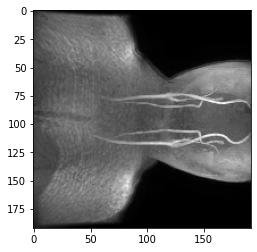

In [20]:
## 데이터셋 확인 (with LDS)
for img, label, weight in train_set:
    print(img.shape)
    print(label)
    print(weight)
    plt.imshow(np.max(img, axis=2).squeeze(), cmap='gray')
    plt.show()
    break

train_mae,▁
train_mse,▁
train_pearson,▁
train_spearman,▁
valid_mae,▁
valid_mse,▁
valid_pearson,▁
valid_spearman,▁
train_mae,0.37381
train_mse,0.32037
train_pearson,0.06528


# EPOCH 1 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 2 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 3 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 4 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.08it/s]


# EPOCH 5 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


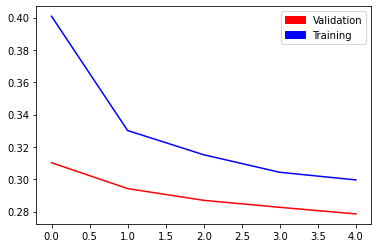

# EPOCH 6 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 7 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.08it/s]


# EPOCH 8 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.04it/s]


# EPOCH 9 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 10 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.09it/s]


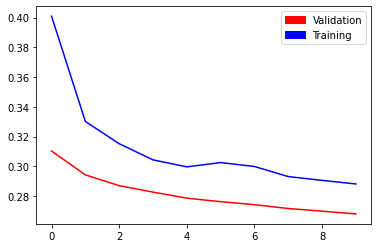

# EPOCH 11 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 12 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 13 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 14 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.10it/s]


# EPOCH 15 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.04it/s]


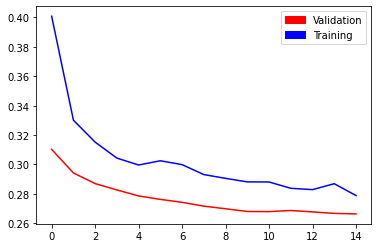

# EPOCH 16 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


# EPOCH 17 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


# EPOCH 18 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 19 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 20 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


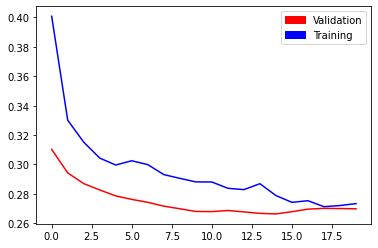

# EPOCH 21 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 22 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 23 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.08it/s]


# EPOCH 24 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


# EPOCH 25 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


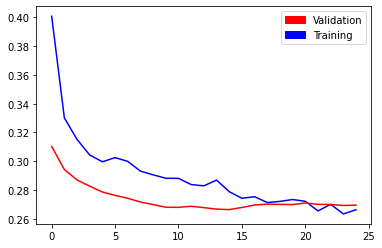

# EPOCH 26 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


# EPOCH 27 / 300


100%|███████████████████████████████████████████| 49/49 [00:22<00:00,  2.15it/s]


# EPOCH 28 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.11it/s]


# EPOCH 29 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


# EPOCH 30 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


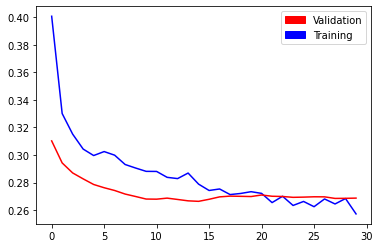

# EPOCH 31 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


# EPOCH 32 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


# EPOCH 33 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 34 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.04it/s]


# EPOCH 35 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


train_mae,▅█▇▆▅▆▅▄▅▄▄▄▄▅▃▃▃▃▄▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁
train_mse,█▅▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁
train_pearson,▁▂▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇▇▇████▇█
train_spearman,▁▃▄▄▅▅▆▆▆▇▆▇▇▆▇▇▇▇▇▇▇▇▇████▇▇█▇████
valid_mae,███▅▆▄▄▂▂▁▂▃▂▂▁▂▄▄▅▄▅▅▅▄▄▄▅▄▅▃▄▄▄▄▄
valid_mse,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▂▂▁
valid_pearson,▁▄▆▆▇▇▇▇███████████████████████████
valid_spearman,▁▄▅▆▆▆▇▇▇▇▇▇████▇▇▇▇███████████████
train_mae,0.32412
train_mse,0.25848
train_pearson,0.43749


# EPOCH 1 / 300


  0%|                                                   | 0/195 [00:00<?, ?it/s]/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 2 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 3 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.04it/s]


# EPOCH 4 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


# EPOCH 5 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 8 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.11it/s]


# EPOCH 9 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 10 / 300


100%|███████████████████████████████████████████| 49/49 [00:22<00:00,  2.13it/s]


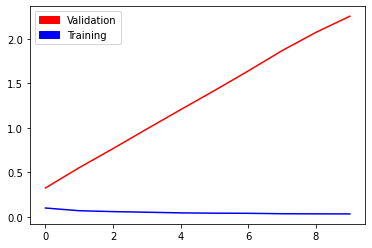

# EPOCH 11 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.04it/s]


# EPOCH 12 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 13 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.08it/s]


# EPOCH 14 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 15 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


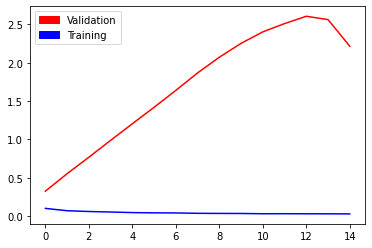

# EPOCH 16 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 17 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 18 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 19 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


# EPOCH 20 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


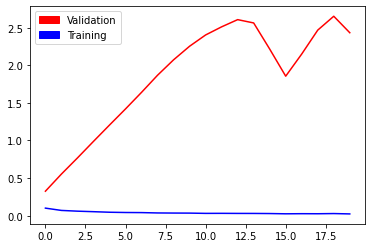

# EPOCH 21 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


train_mae,▁▂▃▄▅▅▆▆▇▇▇████▇▇▇██▇
train_mse,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_pearson,▁▁▁▂▃▃▃▃▄▄▅▅▆▅▆▇▆▆▆██
train_spearman,▁▂▁▃▄▄▄▄▅▅▅▅▆▆▆▆▇▆▆██
valid_mae,▁▃▃▄▅▅▆▇▇▇████▇▆▇███▇
valid_mse,▁▂▂▃▄▄▅▆▆▇▇███▇▆▆▇█▇▆
valid_pearson,▁▃▃▃▃▃▃▄▄▄▆▇█▆▃▃▄▅▆▆▆
valid_spearman,▁▁▁▁▂▂▃▄▄▅▆▆▇▇▆▆▇▇███
train_mae,1.40701
train_mse,0.02362
train_pearson,0.2697


# EPOCH 1 / 300


  0%|                                                   | 0/195 [00:00<?, ?it/s]/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


# EPOCH 2 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


# EPOCH 3 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 4 / 300


 94%|████████████████████████████████████████▎  | 46/49 [00:22<00:00,  6.94it/s]

In [ ]:
# V-Net-1, average pooling layer filter size 5, lds & fds
for lds, fds in [(False,True), (True,False), (True,True), (False,False)]:
    normalization = 'groupnorm'
    num_epochs = 300
    weight_decay = 0.01
    lr = 1e-06
    optim_class = optim.AdamW
    dropout_rate = 0.
    blocknum = 1
    avg_pool = 5
    start_update = 0
    patience = 20
    patience_cnt = 0

    weight_filename = 'pretrained/230518_ieie_vnet-{}-pool{}'.format(blocknum, avg_pool)
    if lds:
        weight_filename += '+lds'
    if fds:
        weight_filename += '+fds'

    ### VNet pretrained model 가져오기
    set_seed()

    out_size = 2 ** blocknum
    out_size = 192 // out_size
    out_size = out_size // avg_pool
    num_fc = [out_size * out_size * out_size,30,16,4]
    net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                    fc_features=[*num_fc], avg_shape=avg_pool, dropout_p=dropout_rate, fds=fds)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
    net.cuda()

    ### Parameter freeze X
    #     for i, [name, param] in enumerate(net.named_parameters()):
    #         if 'encoder' in name:
    #             param.requires_grad = False

    ### W&B 설정
    wandb.init(
        project='202304-IEIE',
        config={"model": "VNet-{}".format(blocknum),
                "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
                "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
                "lds": lds, "fds": fds, "avg_pool_filter": avg_pool},
        notes='train with %d data'%(len(train_set)))
    wandb.watch(net)

    ### 학습 시작
    train_losses = []
    validation_losses = []
    min_valid_loss = 1.0

    optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    set_seed()
    for epoch in range(num_epochs):
        # train set
        augment = get_augmentation_transform()
        train_set.transform = tio.transforms.Compose([preprocess, augment])
        train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

        print('# EPOCH %d / %d'%(epoch+1, num_epochs))

        preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
        preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(test_loader)
        valid_mse = mse_v / len(test_loader)

        if min_valid_loss > valid_mse:
            min_valid_loss = valid_mse
            torch.save(net.state_dict(), weight_filename)
            patience_cnt = 0
        else:
            patience_cnt += 1

        if patience_cnt >= patience:
            wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                       "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
            break

        train_losses.append(train_mse)
        validation_losses.append(valid_mse)
        if (epoch+1)%5 == 0:
            # loss curve
            plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
            red_patch = mpatches.Patch(color='red', label='Validation')
            blue_patch = mpatches.Patch(color='blue', label='Training')
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

# EPOCH 1 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


# EPOCH 2 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 3 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.04it/s]


# EPOCH 4 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 5 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


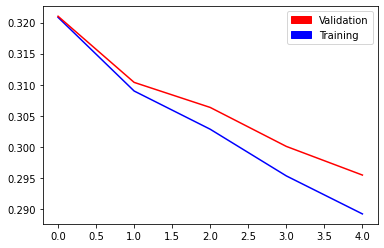

# EPOCH 6 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


# EPOCH 7 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.08it/s]


# EPOCH 8 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.10it/s]


# EPOCH 9 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


# EPOCH 10 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


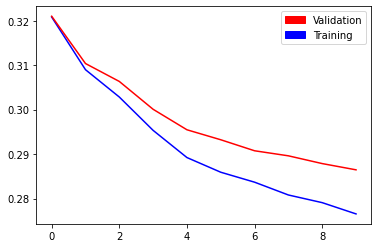

# EPOCH 11 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.04it/s]


# EPOCH 12 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.04it/s]


# EPOCH 13 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.09it/s]


# EPOCH 14 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 15 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


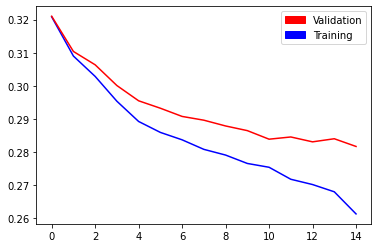

# EPOCH 16 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 17 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 18 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 19 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 20 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.06it/s]


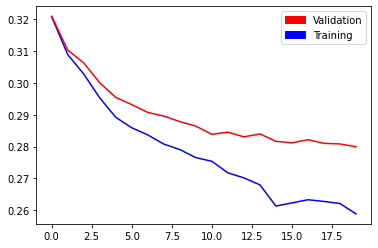

# EPOCH 21 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.93it/s]


# EPOCH 22 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 23 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 24 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 25 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


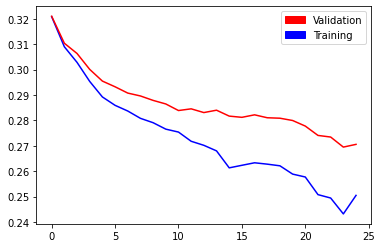

# EPOCH 26 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


# EPOCH 27 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 28 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 29 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


# EPOCH 30 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


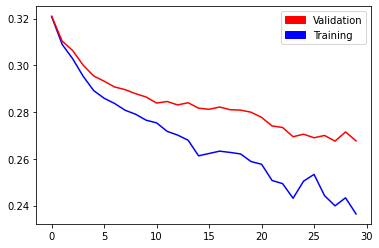

# EPOCH 31 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 32 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 33 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 34 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.96it/s]


# EPOCH 35 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


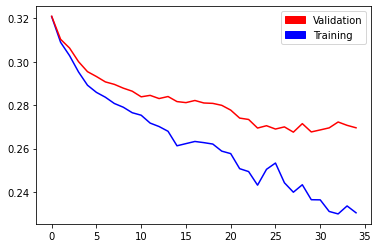

# EPOCH 36 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 37 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# EPOCH 38 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 39 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 40 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


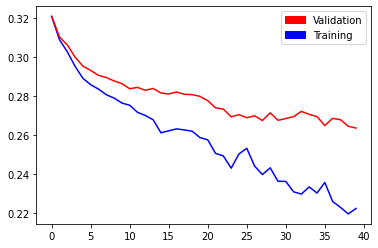

# EPOCH 41 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 42 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 43 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 44 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.96it/s]


# EPOCH 45 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


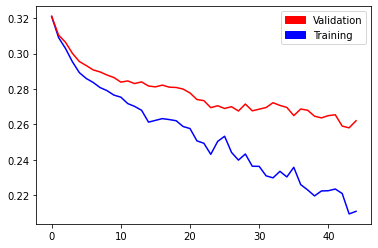

# EPOCH 46 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 47 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.96it/s]


# EPOCH 48 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.92it/s]


# EPOCH 49 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# EPOCH 50 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


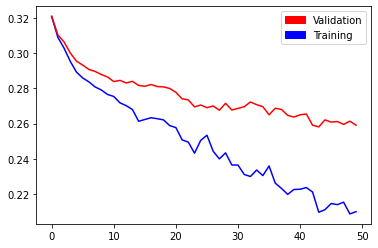

# EPOCH 51 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 52 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 53 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 54 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.92it/s]


# EPOCH 55 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.96it/s]


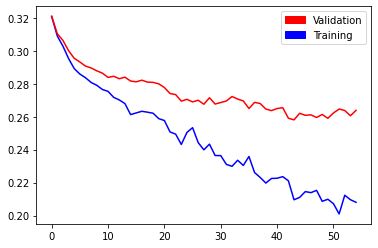

# EPOCH 56 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 57 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 58 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 59 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 60 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


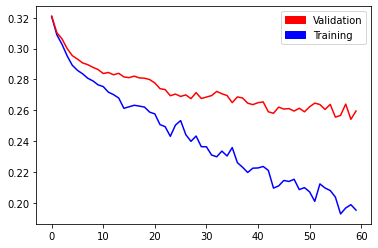

# EPOCH 61 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


# EPOCH 62 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# EPOCH 63 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 64 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 65 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.93it/s]


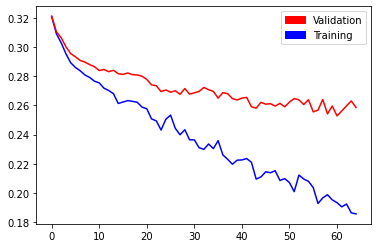

# EPOCH 66 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.93it/s]


# EPOCH 67 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 68 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.04it/s]


# EPOCH 69 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 70 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


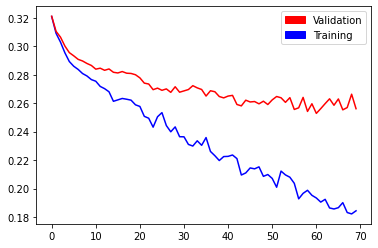

# EPOCH 71 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 72 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.96it/s]


# EPOCH 73 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 74 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 75 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


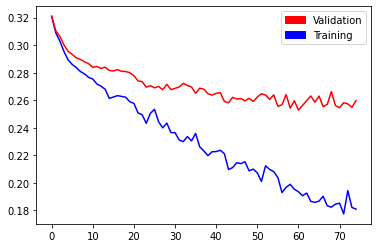

# EPOCH 76 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 77 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.91it/s]


# EPOCH 78 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 79 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 80 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.93it/s]


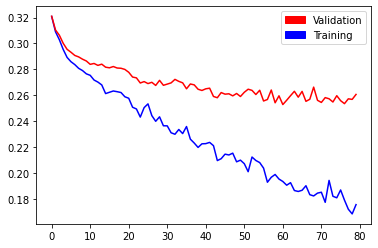

# EPOCH 81 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


train_mae,█▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁
train_mse,█▇▇▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▂▁▁
train_pearson,▁▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_spearman,▁▃▄▄▅▅▅▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇██▇██▇██▇██
valid_mae,█▇▅▅▄▄▅▄▅▅▄▄▄▄▄▃▄▃▄▂▃▁▂▁▂▃▁▂▃▂▂▄▂▁▂▂▂▁▂▁
valid_mse,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▂▃▃▂▂▂▁▂▂▁▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁
valid_pearson,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇▇█▇███▇███████
valid_spearman,▁▃▄▅▅▆▆▆▆▆▆▇▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_mae,0.26187
train_mse,0.17416
train_pearson,0.68027


# EPOCH 1 / 300


  0%|                                                   | 0/195 [00:00<?, ?it/s]/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.96it/s]


# EPOCH 2 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.04it/s]


# EPOCH 3 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 4 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.91it/s]


# EPOCH 5 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


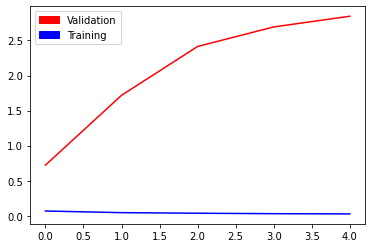

# EPOCH 6 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 7 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.92it/s]


# EPOCH 8 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 9 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 10 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


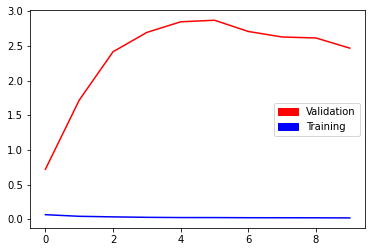

# EPOCH 11 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 12 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 13 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# EPOCH 14 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 15 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


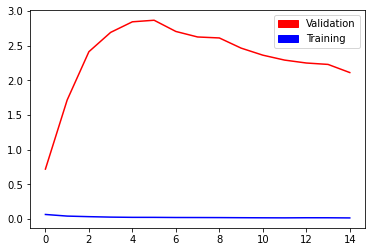

# EPOCH 16 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 17 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 18 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.93it/s]


# EPOCH 19 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 20 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


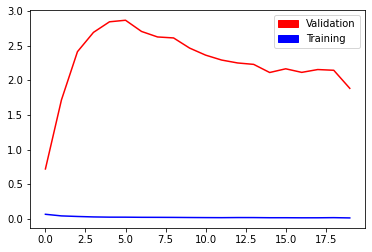

# EPOCH 21 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


train_mae,▁▄▆▇████▇▇▇▇▆▇▆▆▆▆▆▆▅
train_mse,█▅▄▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▁
train_pearson,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
train_spearman,▁▂▄▄▆▆▆▇▇▇▆▇▇▇▇▇█▇▇██
valid_mae,▁▅▇████▇▇▇▆▆▆▆▅▆▅▅▅▅▅
valid_mse,▁▄▇▇██▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅
valid_pearson,▁▅▆▇▇█████▇▇▇████████
valid_spearman,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇██████
train_mae,1.22719
train_mse,0.01506
train_pearson,0.34575


# EPOCH 1 / 300


  0%|                                                   | 0/195 [00:00<?, ?it/s]/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 2 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 3 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 4 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


# EPOCH 5 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


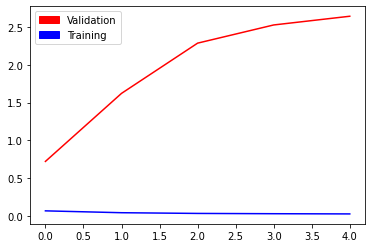

# EPOCH 6 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.04it/s]


# EPOCH 7 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 8 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


# EPOCH 9 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 10 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.05it/s]


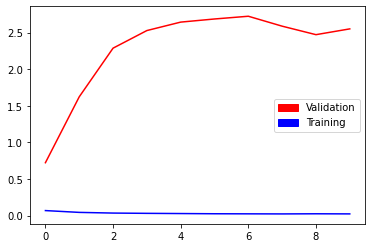

# EPOCH 11 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 12 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 13 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 14 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 15 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


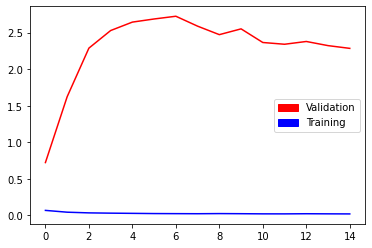

# EPOCH 16 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


# EPOCH 17 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 18 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 19 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 20 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


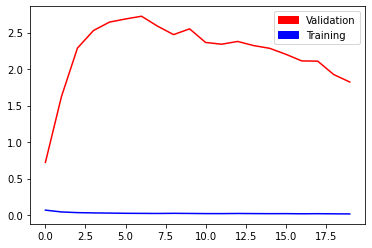

# EPOCH 21 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


train_mae,▁▄▆█████▇█▇▇▇▇▇▇▆▆▆▅▅
train_mse,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁
train_pearson,▁▃▃▅▅▆▇▆▆▆▇▇▇▇▇▇█▇███
train_spearman,▁▂▃▅▅▆▇▇▇▆▇▇▇█▇██▇███
valid_mae,▁▅▇█████▇▇▇▇▇▆▆▆▆▆▅▅▅
valid_mse,▁▄▆▇████▇▇▇▇▇▇▆▆▆▆▅▅▅
valid_pearson,▁▅▆▇████▇▇▇▇█████████
valid_spearman,▁▄▆▇▇▇▇▇▇▇▇▇█████████
train_mae,1.21556
train_mse,0.01503
train_pearson,0.3151


# EPOCH 1 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# EPOCH 2 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 3 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.93it/s]


# EPOCH 4 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 5 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


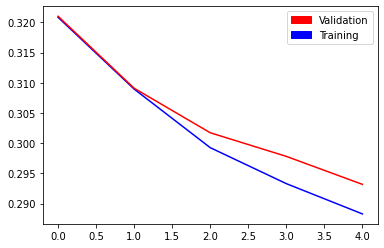

# EPOCH 6 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 7 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 8 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 9 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.96it/s]


# EPOCH 10 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


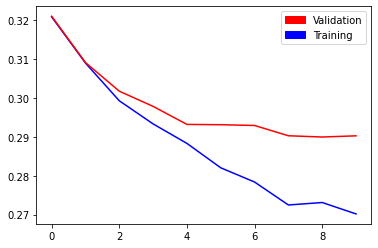

# EPOCH 11 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 12 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 13 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 14 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 15 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


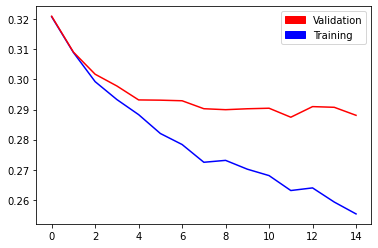

# EPOCH 16 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 17 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 18 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 19 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.96it/s]


# EPOCH 20 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.93it/s]


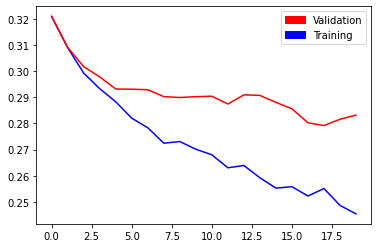

# EPOCH 21 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# EPOCH 22 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.04it/s]


# EPOCH 23 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 24 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 25 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


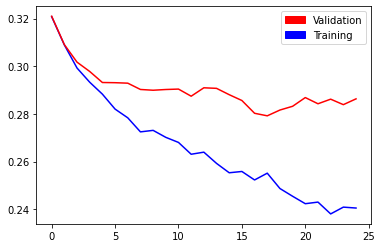

# EPOCH 26 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.04it/s]


# EPOCH 27 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 28 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 29 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# EPOCH 30 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


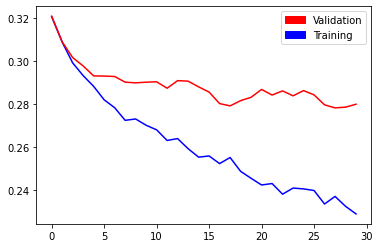

# EPOCH 31 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.96it/s]


# EPOCH 32 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.96it/s]


# EPOCH 33 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 34 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


# EPOCH 35 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


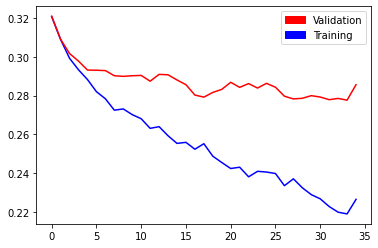

# EPOCH 36 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.93it/s]


# EPOCH 37 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# EPOCH 38 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 39 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 40 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


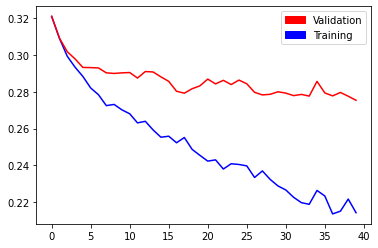

# EPOCH 41 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 42 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 43 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.96it/s]


# EPOCH 44 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 45 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


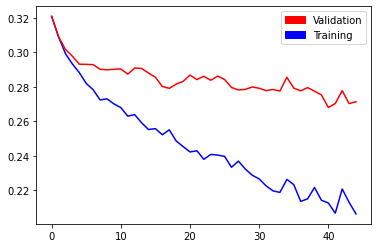

# EPOCH 46 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.92it/s]


# EPOCH 47 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 48 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 49 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.93it/s]


# EPOCH 50 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


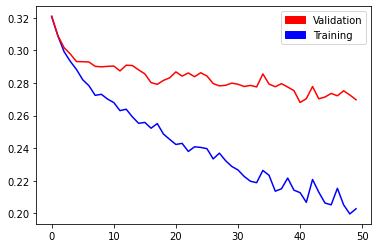

# EPOCH 51 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 52 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 53 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 54 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 55 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.91it/s]


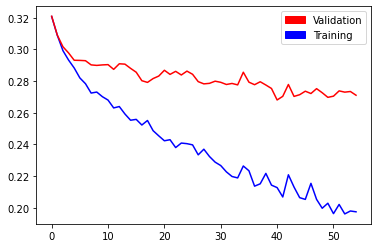

# EPOCH 56 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 57 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


# EPOCH 58 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


# EPOCH 59 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# EPOCH 60 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


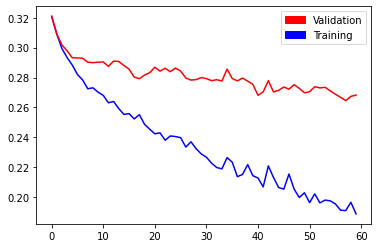

# EPOCH 61 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 62 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 63 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 64 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 65 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.07it/s]


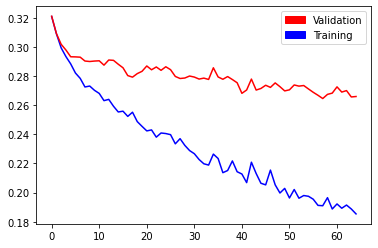

# EPOCH 66 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 67 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 68 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 69 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 70 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


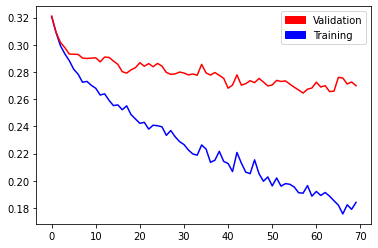

# EPOCH 71 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 72 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 73 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 74 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 75 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.96it/s]


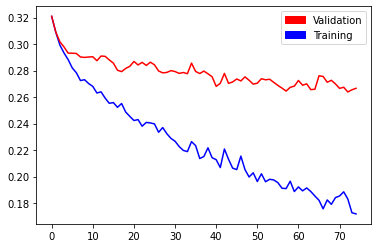

# EPOCH 76 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 77 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 78 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 79 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


# EPOCH 80 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


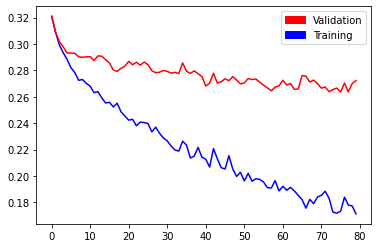

# EPOCH 81 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 82 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 83 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 84 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 85 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.96it/s]


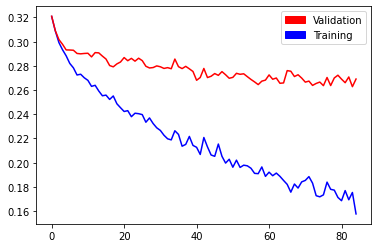

# EPOCH 86 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


# EPOCH 87 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


# EPOCH 88 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.98it/s]


# EPOCH 89 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 90 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


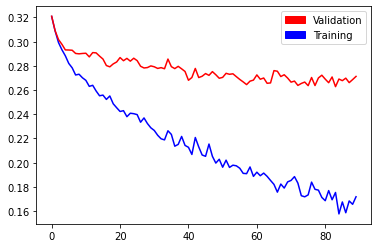

# EPOCH 91 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.00it/s]


# EPOCH 92 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 93 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.94it/s]


# EPOCH 94 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 95 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.99it/s]


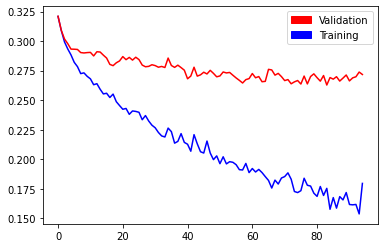

# EPOCH 96 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.01it/s]


# EPOCH 97 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


# EPOCH 98 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 99 / 300


100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.04it/s]


# EPOCH 100 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


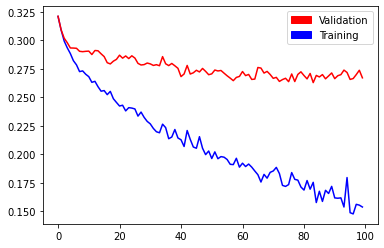

# EPOCH 101 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.03it/s]


# EPOCH 102 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  1.97it/s]


# EPOCH 103 / 300


100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.95it/s]


# EPOCH 104 / 300


100%|███████████████████████████████████████████| 49/49 [00:24<00:00,  2.02it/s]


train_mae,█▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▁▁▁
train_mse,█▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▃▃▂▃▂▃▂▂▂▂▁▂▁▁
train_pearson,▁▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇████
train_spearman,▁▃▄▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█████
valid_mae,█▅▅▄▄▄▂▃▃▂▃▃▂▃▃▃▄▂▃▂▂▂▃▃▂▂▂▁▁▁▂▃▂▁▄▁▂▁▂▂
valid_mse,█▆▄▄▄▄▄▃▃▃▃▃▃▄▃▂▃▂▂▂▂▁▁▂▁▂▂▁▁▂▂▁▁▁▂▂▁▂▁▂
valid_pearson,▁▄▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇██▇█▇▇██▇▇████▇████
valid_spearman,▁▃▅▅▆▆▆▇▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
train_mae,0.23985
train_mse,0.13648
train_pearson,0.7626


In [27]:
# V-Net-1, average pooling layer filter size 3, lds & fds
for lds, fds in [(False,True), (True,False), (True,True), (False,False)]:
    normalization = 'groupnorm'
    num_epochs = 300
    weight_decay = 0.01
    lr = 1e-06
    optim_class = optim.AdamW
    dropout_rate = 0.
    blocknum = 1
    avg_pool = 3
    start_update = 0
    patience = 20
    patience_cnt = 0

    weight_filename = 'pretrained/230518_ieie_vnet-{}-pool{}'.format(blocknum, avg_pool)
    if lds:
        weight_filename += '+lds'
    if fds:
        weight_filename += '+fds'

    ### VNet pretrained model 가져오기
    set_seed()

    out_size = 2 ** blocknum
    out_size = 192 // out_size
    out_size = out_size // avg_pool
    num_fc = [out_size * out_size * out_size,30,16,4]
    net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                    fc_features=[*num_fc], avg_shape=avg_pool, dropout_p=dropout_rate, fds=fds)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
    net.cuda()

    ### Parameter freeze X
    #     for i, [name, param] in enumerate(net.named_parameters()):
    #         if 'encoder' in name:
    #             param.requires_grad = False

    ### W&B 설정
    wandb.init(
        project='202304-IEIE',
        config={"model": "VNet-{}".format(blocknum),
                "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
                "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
                "lds": lds, "fds": fds, "avg_pool_filter": avg_pool},
        notes='train with %d data'%(len(train_set)))
    wandb.watch(net)

    ### 학습 시작
    train_losses = []
    validation_losses = []
    min_valid_loss = 1.0

    optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    set_seed()
    for epoch in range(num_epochs):
        # train set
        augment = get_augmentation_transform()
        train_set.transform = tio.transforms.Compose([preprocess, augment])
        train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

        print('# EPOCH %d / %d'%(epoch+1, num_epochs))

        preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
        preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(test_loader)
        valid_mse = mse_v / len(test_loader)

        if min_valid_loss > valid_mse:
            min_valid_loss = valid_mse
            torch.save(net.state_dict(), weight_filename)
            patience_cnt = 0
        else:
            patience_cnt += 1

        if patience_cnt >= patience:
            wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                       "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
            break

        train_losses.append(train_mse)
        validation_losses.append(valid_mse)
        if (epoch+1)%5 == 0:
            # loss curve
            plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
            red_patch = mpatches.Patch(color='red', label='Validation')
            blue_patch = mpatches.Patch(color='blue', label='Training')
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# EPOCH 1 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.64it/s]


# EPOCH 2 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 3 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]


# EPOCH 4 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 5 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


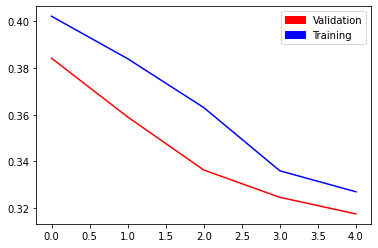

# EPOCH 6 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


# EPOCH 7 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


# EPOCH 8 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 9 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 10 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


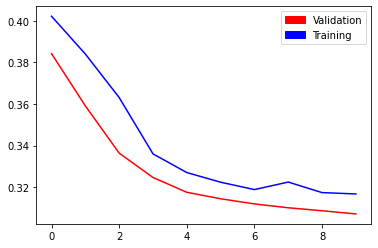

# EPOCH 11 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 12 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 13 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 14 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 15 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


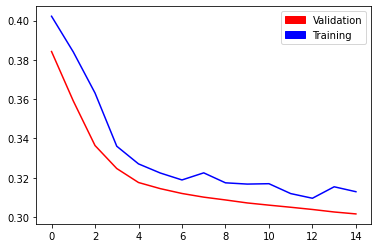

# EPOCH 16 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 17 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 18 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 19 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 20 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


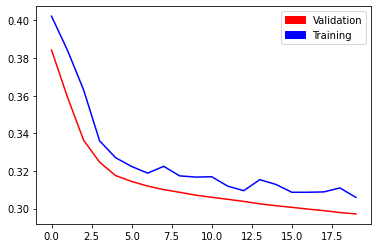

# EPOCH 21 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 22 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 23 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 24 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


# EPOCH 25 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


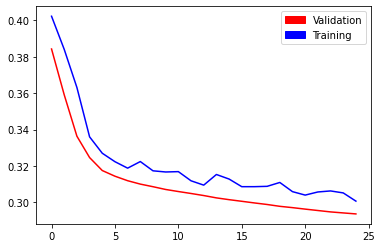

# EPOCH 26 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 27 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 28 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 29 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 30 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


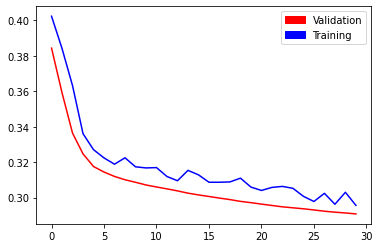

# EPOCH 31 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 32 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 33 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 34 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 35 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


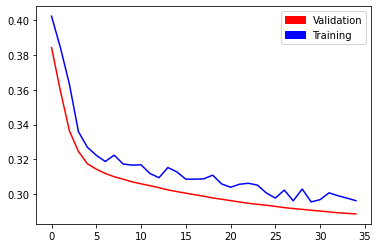

# EPOCH 36 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 37 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 38 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 39 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 40 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


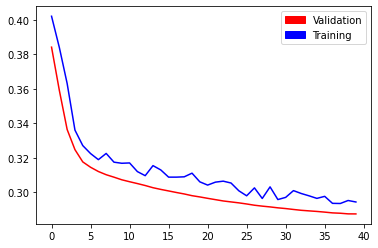

# EPOCH 41 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 42 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 43 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.75it/s]


# EPOCH 44 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 45 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


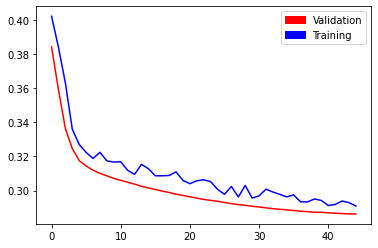

# EPOCH 46 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 47 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 48 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 49 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 50 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.76it/s]


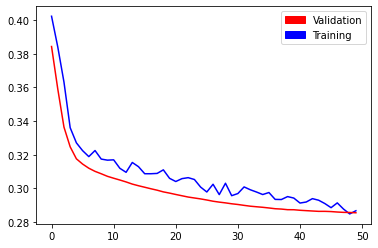

# EPOCH 51 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.75it/s]


# EPOCH 52 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 53 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 54 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 55 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


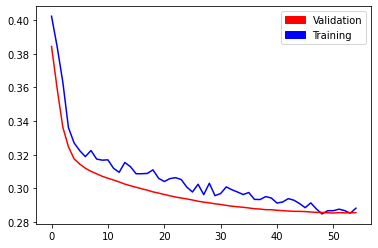

# EPOCH 56 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 57 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 58 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 59 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 60 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


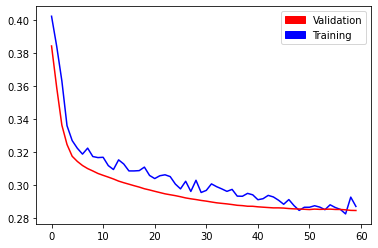

# EPOCH 61 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 62 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 63 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 64 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 65 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


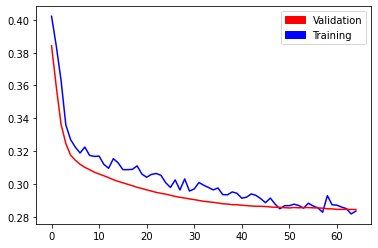

# EPOCH 66 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 67 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


# EPOCH 68 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 69 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 70 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


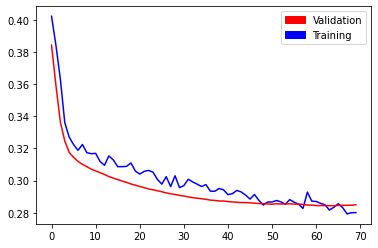

# EPOCH 71 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 72 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 73 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 74 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 75 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


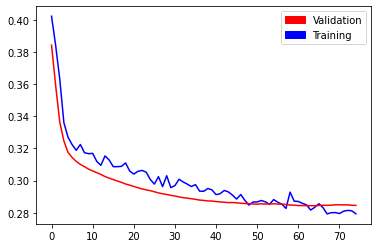

# EPOCH 76 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 77 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 78 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 79 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 80 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.75it/s]


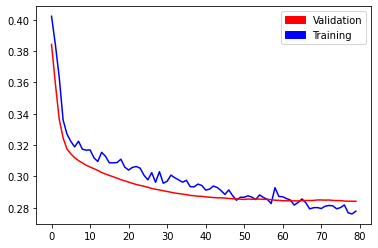

# EPOCH 81 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]


# EPOCH 82 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 83 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.76it/s]


# EPOCH 84 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 85 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


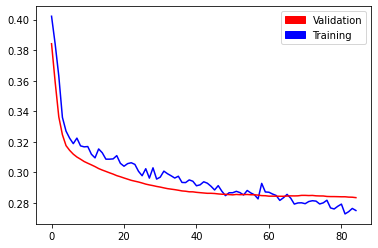

# EPOCH 86 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 87 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 88 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 89 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 90 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


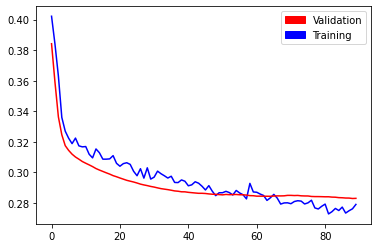

# EPOCH 91 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 92 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 93 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 94 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 95 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


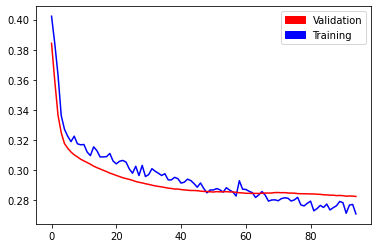

# EPOCH 96 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 97 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.75it/s]


# EPOCH 98 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.75it/s]


# EPOCH 99 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 100 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.75it/s]


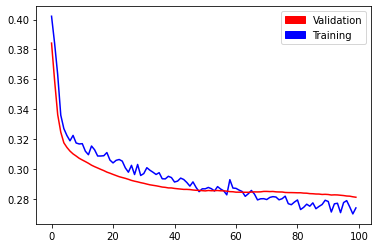

# EPOCH 101 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 102 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 103 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 104 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 105 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


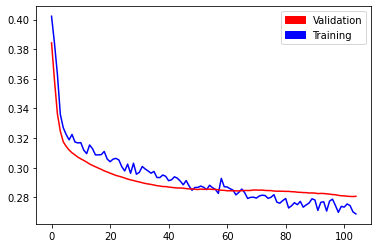

# EPOCH 106 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 107 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 108 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 109 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 110 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


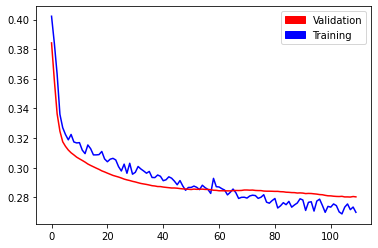

# EPOCH 111 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 112 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 113 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 114 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 115 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


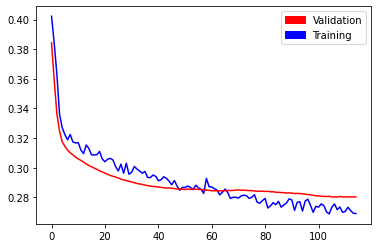

# EPOCH 116 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 117 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


# EPOCH 118 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 119 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 120 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


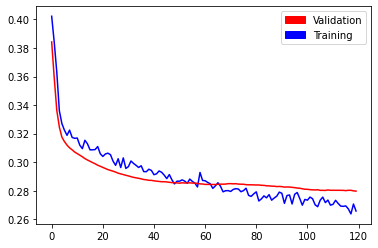

# EPOCH 121 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 122 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 123 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 124 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 125 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


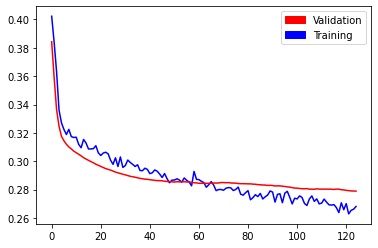

# EPOCH 126 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 127 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 128 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 129 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 130 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


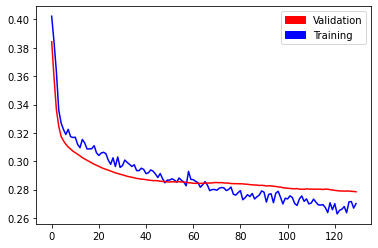

# EPOCH 131 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 132 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 133 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 134 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 135 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


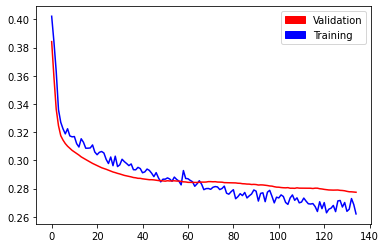

# EPOCH 136 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 137 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 138 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 139 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 140 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


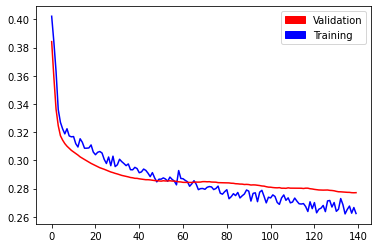

# EPOCH 141 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 142 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 143 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 144 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 145 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


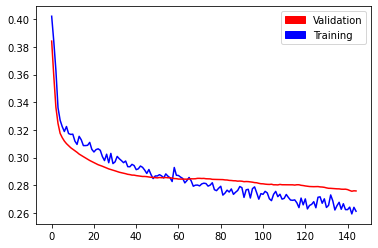

# EPOCH 146 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 147 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 148 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 149 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 150 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


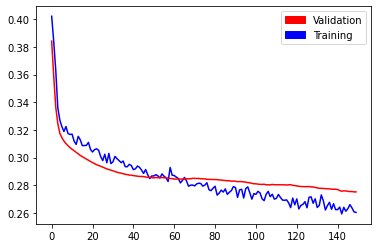

# EPOCH 151 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


# EPOCH 152 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 153 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 154 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 155 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


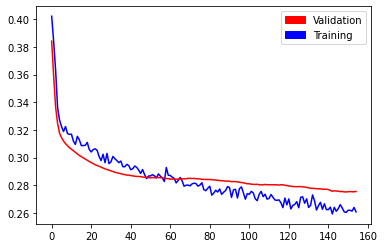

# EPOCH 156 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 157 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 158 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 159 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 160 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


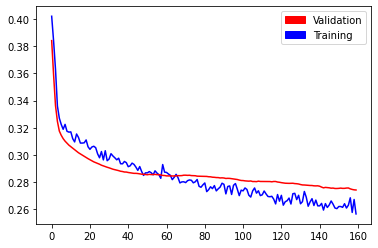

# EPOCH 161 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.66it/s]


# EPOCH 162 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 163 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 164 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 165 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


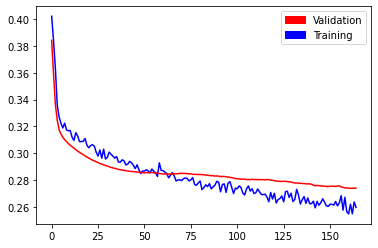

# EPOCH 166 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 167 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 168 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 169 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 170 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


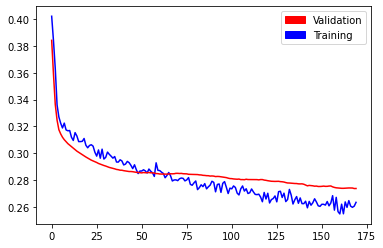

# EPOCH 171 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 172 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 173 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 174 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]


# EPOCH 175 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


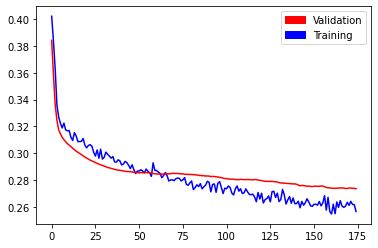

# EPOCH 176 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 177 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 178 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 179 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 180 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]


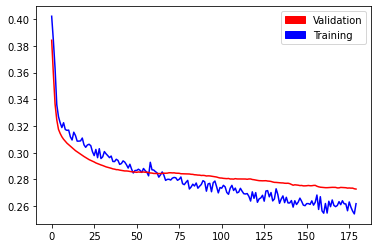

# EPOCH 181 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 182 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 183 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 184 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 185 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.76it/s]


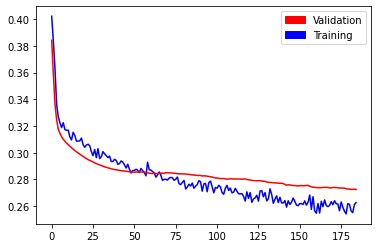

# EPOCH 186 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 187 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 188 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 189 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 190 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


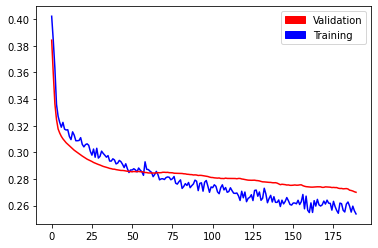

# EPOCH 191 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 192 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 193 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 194 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 195 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


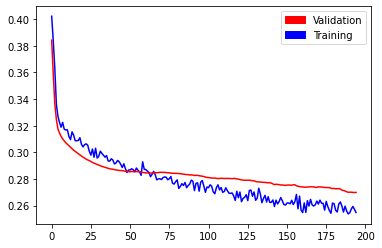

# EPOCH 196 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 197 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 198 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


# EPOCH 199 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 200 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


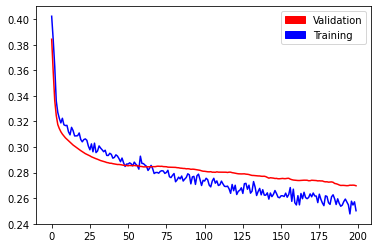

# EPOCH 201 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 202 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 203 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 204 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 205 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


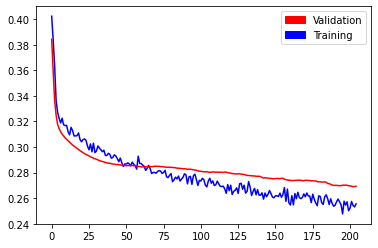

# EPOCH 206 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 207 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 208 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 209 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 210 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


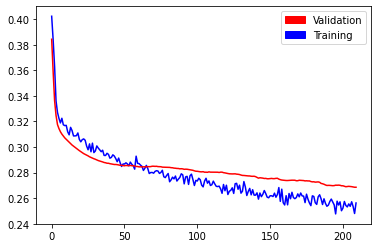

# EPOCH 211 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 212 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 213 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 214 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 215 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


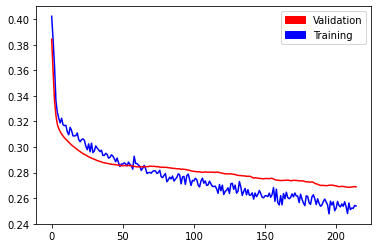

# EPOCH 216 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.77it/s]


# EPOCH 217 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]


# EPOCH 218 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 219 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 220 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


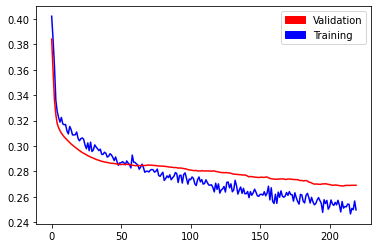

# EPOCH 221 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 222 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 223 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 224 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 225 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


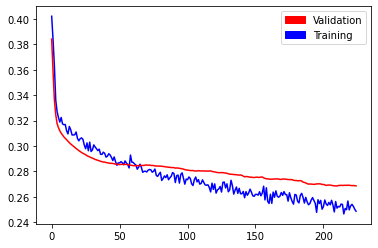

# EPOCH 226 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 227 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 228 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.76it/s]


# EPOCH 229 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 230 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


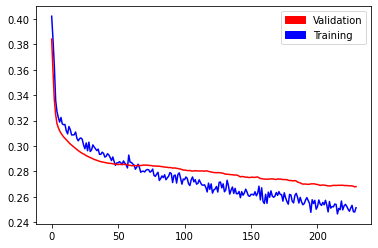

# EPOCH 231 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 232 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 233 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 234 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]


# EPOCH 235 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


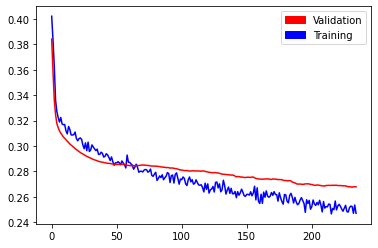

# EPOCH 236 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 237 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 238 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]


# EPOCH 239 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 240 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.75it/s]


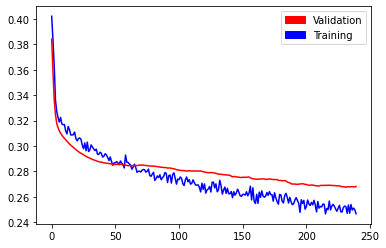

# EPOCH 241 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 242 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 243 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 244 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 245 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


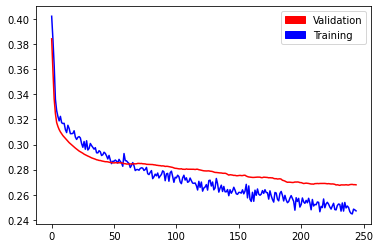

# EPOCH 246 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 247 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.76it/s]


# EPOCH 248 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.73it/s]


# EPOCH 249 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.71it/s]


# EPOCH 250 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


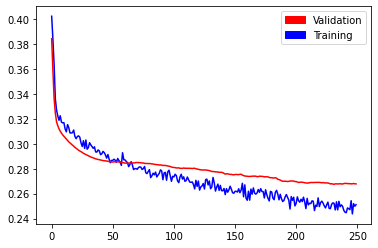

# EPOCH 251 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 252 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.69it/s]


# EPOCH 253 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 254 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 255 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.65it/s]


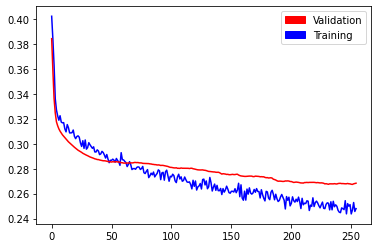

# EPOCH 256 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.68it/s]


# EPOCH 257 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 258 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.69it/s]


# EPOCH 259 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 260 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.76it/s]


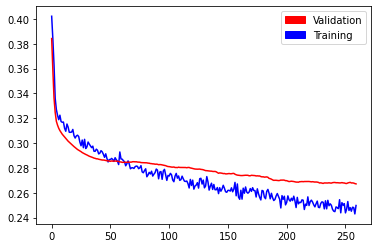

# EPOCH 261 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 262 / 300


100%|███████████████████████████████████████████| 49/49 [00:26<00:00,  1.82it/s]


# EPOCH 263 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.77it/s]


# EPOCH 264 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.79it/s]


# EPOCH 265 / 300


100%|███████████████████████████████████████████| 49/49 [00:26<00:00,  1.83it/s]


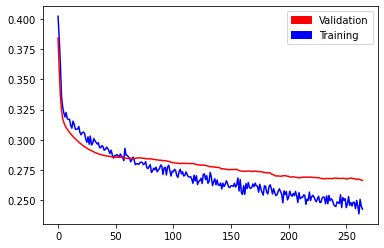

# EPOCH 266 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.78it/s]


# EPOCH 267 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.79it/s]


# EPOCH 268 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.79it/s]


# EPOCH 269 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 270 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.76it/s]


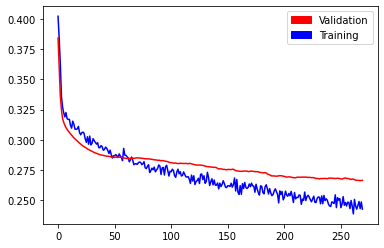

# EPOCH 271 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.77it/s]


# EPOCH 272 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]


# EPOCH 273 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.76it/s]


# EPOCH 274 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.76it/s]


# EPOCH 275 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.79it/s]


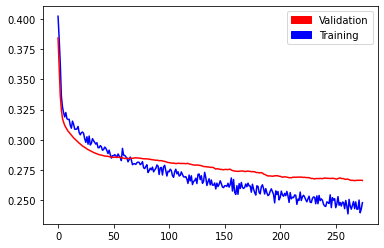

# EPOCH 276 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 277 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.72it/s]


# EPOCH 278 / 300


100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.77it/s]


# EPOCH 279 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]


# EPOCH 280 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.75it/s]


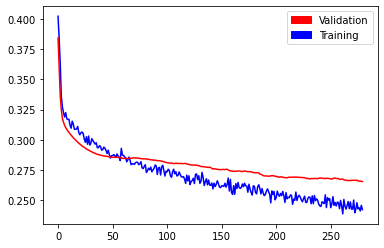

# EPOCH 281 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.74it/s]


# EPOCH 282 / 300


100%|███████████████████████████████████████████| 49/49 [00:28<00:00,  1.70it/s]


# EPOCH 283 / 300


100%|███████████████████████████████████████████| 49/49 [00:29<00:00,  1.67it/s]


# EPOCH 284 / 300


100%|█████████████████████████████████████████| 195/195 [01:36<00:00,  2.01it/s]


KeyboardInterrupt: 

In [21]:
# V-Net-2, average pooling layer filter size 5, lds & fds
for lds, fds in [(False,True), (True,False), (True,True), (False,False)]:
    normalization = 'groupnorm'
    num_epochs = 150
    weight_decay = 0.01
    lr = 1e-06
    optim_class = optim.AdamW
    dropout_rate = 0.
    blocknum = 2
    avg_pool = 5
    start_update = 0
    patience = 20
    patience_cnt = 0

    weight_filename = 'pretrained/230518_ieie_vnet-{}-pool{}'.format(blocknum, avg_pool)
    if lds:
        weight_filename += '+lds'
    if fds:
        weight_filename += '+fds'

    ### VNet pretrained model 가져오기
    set_seed()

    out_size = 2 ** blocknum
    out_size = 192 // out_size
    out_size = out_size // avg_pool
    num_fc = [out_size * out_size * out_size,30,16,4]
    net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                    fc_features=[*num_fc], avg_shape=avg_pool, dropout_p=dropout_rate, fds=fds)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
    net.cuda()

    ### Parameter freeze X
    #     for i, [name, param] in enumerate(net.named_parameters()):
    #         if 'encoder' in name:
    #             param.requires_grad = False

    ### W&B 설정
    wandb.init(
        project='202304-IEIE',
        config={"model": "VNet-{}".format(blocknum),
                "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
                "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
                "lds": lds, "fds": fds, "avg_pool_filter": avg_pool},
        notes='train with %d data'%(len(train_set)))
    wandb.watch(net)

    ### 학습 시작
    train_losses = []
    validation_losses = []
    min_valid_loss = 1.0

    optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    set_seed()
    for epoch in range(num_epochs):
        # train set
        augment = get_augmentation_transform()
        train_set.transform = tio.transforms.Compose([preprocess, augment])
        train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

        print('# EPOCH %d / %d'%(epoch+1, num_epochs))

        preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
        preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(test_loader)
        valid_mse = mse_v / len(test_loader)

        if min_valid_loss > valid_mse:
            min_valid_loss = valid_mse
            torch.save(net.state_dict(), weight_filename)
            patience_cnt = 0
        else:
            patience_cnt += 1

        if patience_cnt >= patience:
            wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                       "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
            break

        train_losses.append(train_mse)
        validation_losses.append(valid_mse)
        if (epoch+1)%5 == 0:
            # loss curve
            plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
            red_patch = mpatches.Patch(color='red', label='Validation')
            blue_patch = mpatches.Patch(color='blue', label='Training')
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

msg = 'V-Net-{}, avg_pool={}, LDS/FDS 적용 실험 종료.'.format(blocknum, avg_pool)
send(msg)

In [ ]:
# V-Net-2, average pooling layer filter size 5, lds & fds
for lds, fds in [(False,True), (True,False), (True,True), (False,False)]:
    normalization = 'groupnorm'
    num_epochs = 150
    weight_decay = 0.01
    lr = 1e-06
    optim_class = optim.AdamW
    dropout_rate = 0.
    blocknum = 2
    avg_pool = 3
    start_update = 0
    patience = 20
    patience_cnt = 0

    weight_filename = 'pretrained/230518_ieie_vnet-{}-pool{}'.format(blocknum, avg_pool)
    if lds:
        weight_filename += '+lds'
    if fds:
        weight_filename += '+fds'

    ### VNet pretrained model 가져오기
    set_seed()

    out_size = 2 ** blocknum
    out_size = 192 // out_size
    out_size = out_size // avg_pool
    num_fc = [out_size * out_size * out_size,30,16,4]
    net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                    fc_features=[*num_fc], avg_shape=avg_pool, dropout_p=dropout_rate, fds=fds)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
    net.cuda()

    ### Parameter freeze X
    #     for i, [name, param] in enumerate(net.named_parameters()):
    #         if 'encoder' in name:
    #             param.requires_grad = False

    ### W&B 설정
    wandb.init(
        project='202304-IEIE',
        config={"model": "VNet-{}".format(blocknum),
                "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
                "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
                "lds": lds, "fds": fds, "avg_pool_filter": avg_pool},
        notes='train with %d data'%(len(train_set)))
    wandb.watch(net)

    ### 학습 시작
    train_losses = []
    validation_losses = []
    min_valid_loss = 1.0

    optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    set_seed()
    for epoch in range(num_epochs):
        # train set
        augment = get_augmentation_transform()
        train_set.transform = tio.transforms.Compose([preprocess, augment])
        train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

        print('# EPOCH %d / %d'%(epoch+1, num_epochs))

        preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
        preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(test_loader)
        valid_mse = mse_v / len(test_loader)

        if min_valid_loss > valid_mse:
            min_valid_loss = valid_mse
            torch.save(net.state_dict(), weight_filename)
            patience_cnt = 0
        else:
            patience_cnt += 1

        if patience_cnt >= patience:
            wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                       "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
            break

        train_losses.append(train_mse)
        validation_losses.append(valid_mse)
        if (epoch+1)%5 == 0:
            # loss curve
            plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
            red_patch = mpatches.Patch(color='red', label='Validation')
            blue_patch = mpatches.Patch(color='blue', label='Training')
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

msg = 'V-Net-{}, avg_pool={}, LDS/FDS 적용 실험 종료.'.format(blocknum, avg_pool)
send(msg)

In [ ]:
# V-Net-3, without avg pooling, lds & fds
for lds, fds in [(False,True), (True,False), (True,True), (False,False)]:
    normalization = 'groupnorm'
    num_epochs = 150
    weight_decay = 0.01
    lr = 1e-06
    optim_class = optim.AdamW
    dropout_rate = 0.
    blocknum = 3
    start_update = 0
    patience = 20
    patience_cnt = 0

    weight_filename = 'pretrained/230518_ieie_vnet-{}'.format(blocknum)
    if lds:
        weight_filename += '+lds'
    if fds:
        weight_filename += '+fds'

    ### VNet pretrained model 가져오기
    set_seed()

    out_size = 2 ** blocknum
    out_size = 192 // out_size
    num_fc = [out_size * out_size * out_size,30,16,4]
    net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                    fc_features=[*num_fc], avg_shape=avg_pool, dropout_p=dropout_rate, fds=fds)
    net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
    net.cuda()

    ### Parameter freeze X
    #     for i, [name, param] in enumerate(net.named_parameters()):
    #         if 'encoder' in name:
    #             param.requires_grad = False

    ### W&B 설정
    wandb.init(
        project='202304-IEIE',
        config={"model": "VNet-{}".format(blocknum),
                "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
                "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
                "lds": lds, "fds": fds},
        notes='train with %d data'%(len(train_set)))
    wandb.watch(net)

    ### 학습 시작
    train_losses = []
    validation_losses = []
    min_valid_loss = 1.0

    optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    set_seed()
    for epoch in range(num_epochs):
        # train set
        augment = get_augmentation_transform()
        train_set.transform = tio.transforms.Compose([preprocess, augment])
        train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

        print('# EPOCH %d / %d'%(epoch+1, num_epochs))

        preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
        preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(test_loader)
        valid_mse = mse_v / len(test_loader)

        if min_valid_loss > valid_mse:
            min_valid_loss = valid_mse
            torch.save(net.state_dict(), weight_filename)
            patience_cnt = 0
        else:
            patience_cnt += 1

        if patience_cnt >= patience:
            wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                       "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
            break

        train_losses.append(train_mse)
        validation_losses.append(valid_mse)
        if (epoch+1)%5 == 0:
            # loss curve
            plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
            red_patch = mpatches.Patch(color='red', label='Validation')
            blue_patch = mpatches.Patch(color='blue', label='Training')
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

msg = 'V-Net-{}, avg_pool=X, LDS/FDS 적용 실험 종료.'.format(blocknum)
send(msg)

In [ ]:
# V-Net-4, without avg pooling, lds & fds
for fds in [False, True]:
    normalization = 'groupnorm'
    num_epochs = 150
    weight_decay = 0.01
    lr = 1e-06
    optim_class = optim.AdamW
    dropout_rate = 0.
    blocknum = 4
    start_update = 0
    patience = 20
    patience_cnt = 0

    weight_filename = 'pretrained/230518_ieie_vnet-{}'.format(blocknum)
    if lds:
        weight_filename += '+lds'
    if fds:
        weight_filename += '+fds'

    ### VNet pretrained model 가져오기
    set_seed()

    out_size = 2 ** blocknum
    out_size = 192 // out_size
    num_fc = [out_size * out_size * out_size,30,16,4]
    net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                    fc_features=[*num_fc], avg_shape=avg_pool, dropout_p=dropout_rate, fds=fds)
    net.conv_out = nn.Conv3d(net.n_filters, 1, 1, padding=0)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)), strict=False)
    net.cuda()

    ### Parameter freeze X
    #     for i, [name, param] in enumerate(net.named_parameters()):
    #         if 'encoder' in name:
    #             param.requires_grad = False

    ### W&B 설정
    wandb.init(
        project='202304-IEIE',
        config={"model": "VNet-{}".format(blocknum),
                "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
                "cost_function": "mse", "optimizer": optim_class.__name__, "weight_decay": weight_decay,
                "lds": lds, "fds": fds},
        notes='train with %d data'%(len(train_set)))
    wandb.watch(net)

    ### 학습 시작
    train_losses = []
    validation_losses = []
    min_valid_loss = 1.0

    optimizer = optim_class(net.parameters(), lr=lr, weight_decay=weight_decay)
    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    set_seed()
    for epoch in range(num_epochs):
        # train set
        augment = get_augmentation_transform()
        train_set.transform = tio.transforms.Compose([preprocess, augment])
        train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

        print('# EPOCH %d / %d'%(epoch+1, num_epochs))

        preds_t, truths_t, mse_t, mae_t = train(net, train_loader, optimizer, epoch=epoch, lds=lds, fds=fds)
        preds_v, truths_v, mse_v, mae_v = valid(net, test_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(test_loader)
        valid_mse = mse_v / len(test_loader)

        if min_valid_loss > valid_mse:
            min_valid_loss = valid_mse
            torch.save(net.state_dict(), weight_filename)
            patience_cnt = 0
        else:
            patience_cnt += 1

        if patience_cnt >= patience:
            wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                       "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
            break

        train_losses.append(train_mse)
        validation_losses.append(valid_mse)
        if (epoch+1)%5 == 0:
            # loss curve
            plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
            red_patch = mpatches.Patch(color='red', label='Validation')
            blue_patch = mpatches.Patch(color='blue', label='Training')
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

msg = 'V-Net-{}, avg_pool=X, LDS/FDS 적용 실험 종료.'.format(blocknum)
send(msg)

In [50]:
"""https://gmnam.tistory.com/302"""
import seaborn as sns
from models.regression_loss import RMSELoss

def predict(model, data_loader, title='', line=False, legend=False):
    mae_loss = nn.L1Loss()
    rmse_loss = RMSELoss()
    total_mae, total_rmse = 0, 0
    
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels, _ in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            
            mae = mae_loss(output, labels)
            rmse = rmse_loss(output, labels)
            
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
            
            total_mae += mae.data.item()
            total_rmse += rmse.data.item()
        
    # Get metrics
    mae = total_mae / len(data_loader)
    rmse = total_rmse / len(data_loader)
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
#     r2 = pearson**2
    ssr = np.sum((preds - np.mean(truths))**2)  # sum of square of regression
    sse = np.sum((truths - preds)**2)  # sum of square of errors
    sst = ssr + sse  # total sum of squares
    r2 = ssr/sst  # R-Squared = SSR/SST = 1-(SSE/SST)
    
    # For range setting
    _min = preds.min() - 0.5
    _max = preds.max() + 0.5
        
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='steelblue')
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='steelblue', label='m = {:.2f}'.format(m))
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='steelblue', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    if legend:
        plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return mae, rmse, r2, pearson, spearman

VNet-1


100%|███████████████████████████████████████████| 49/49 [00:37<00:00,  1.31it/s]


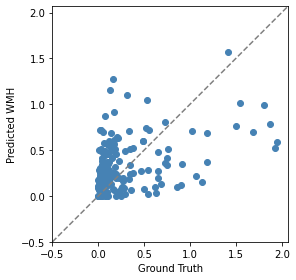

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.30	0.40	0.26		0.52		0.43



In [55]:
print("VNet-1")
normalization = 'groupnorm'
blocknum = 1
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230430_ieie_vnet-{}'.format(blocknum)))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-2


100%|███████████████████████████████████████████| 49/49 [00:37<00:00,  1.29it/s]


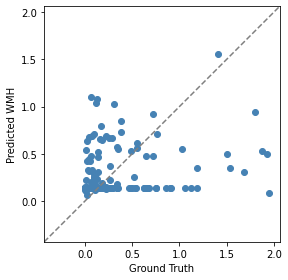

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.29	0.40	0.19		0.41		0.35



In [56]:
print("VNet-2")
normalization = 'groupnorm'
blocknum = 2
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230430_ieie_vnet-{}'.format(blocknum)))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-3


100%|███████████████████████████████████████████| 49/49 [00:37<00:00,  1.30it/s]


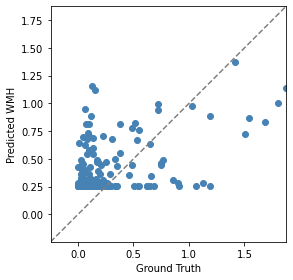

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.33	0.41	0.21		0.51		0.40



In [57]:
print("VNet-3")
normalization = 'groupnorm'
blocknum = 3
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230430_ieie_vnet-{}'.format(blocknum)))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

VNet-4


100%|███████████████████████████████████████████| 49/49 [00:35<00:00,  1.37it/s]


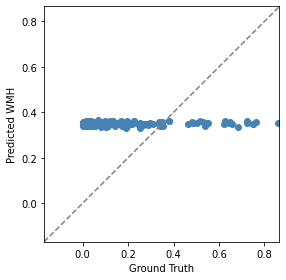

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.36	0.45	0.00		0.28		0.23



In [59]:
print("VNet-4")
blocknum = 4
out_size = 2 ** blocknum
out_size = 192 // out_size
num_fc = [out_size * out_size * out_size,30,16,4]
net = Regressor(n_channels=1, n_classes=2, out_features=1, normalization=normalization, n_blocks=blocknum,
                fc_features=[*num_fc])
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230430_ieie_vnet-{}'.format(blocknum)))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

SE-SFCN


100%|███████████████████████████████████████████| 49/49 [00:38<00:00,  1.27it/s]


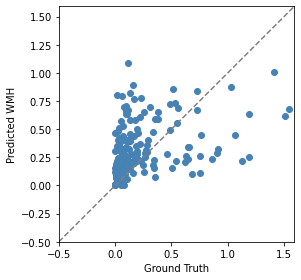

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.30	0.40	0.19		0.47		0.55



In [64]:
print("SE-SFCN")
def forward(self, x):
    x = self.feature_extractor(x)
    # add SEBlock
    x = self.seblock(x)*x
    x = self.classifier(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

net = SFCN()
net.seblock = SEBlock(64)
net.fc = nn.Sequential(
    nn.Linear(384, 1),
    nn.LeakyReLU(),
)
net.forward = types.MethodType(forward, net)
net.load_state_dict(torch.load('pretrained/230430_ieie_se-sfcn'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

SFCN


100%|███████████████████████████████████████████| 49/49 [00:38<00:00,  1.27it/s]


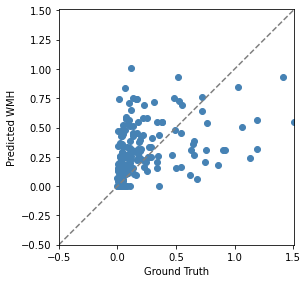

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.29	0.39	0.19		0.50		0.57



In [65]:
print("SFCN")
net = SFCN()
net.fc = nn.Sequential(
    nn.Linear(384, 1),
    nn.LeakyReLU(),
)
net.load_state_dict(torch.load('pretrained/230430_ieie_sfcn'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

Resnet10


100%|███████████████████████████████████████████| 49/49 [00:39<00:00,  1.26it/s]


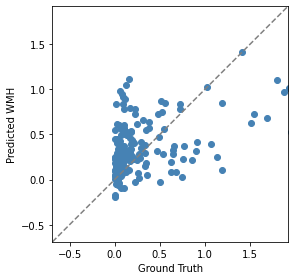

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.31	0.41	0.25		0.46		0.49



In [66]:
print("Resnet10")
net = resnet(model_depth=10, in_channels=1, num_classes=1)
net.load_state_dict(torch.load('pretrained/230430_ieie_resnet10'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

In [ ]:
print("Resnet18")
net = resnet(model_depth=18, in_channels=1, num_classes=1)
net.load_state_dict(torch.load('pretrained/230430_ieie_resnet18'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

Resnet26


100%|███████████████████████████████████████████| 49/49 [00:39<00:00,  1.25it/s]


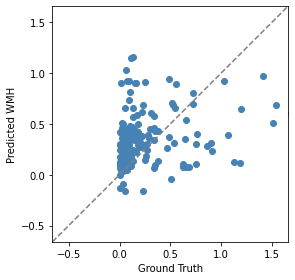

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.33	0.43	0.21		0.41		0.44



In [67]:
print("Resnet26")
net = resnet26(in_channels=1, num_classes=1)
net.load_state_dict(torch.load('pretrained/230430_ieie_resnet26'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

Inception-Resnet-v2


100%|███████████████████████████████████████████| 49/49 [00:37<00:00,  1.30it/s]


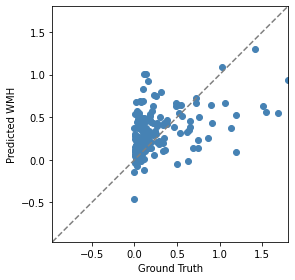

------------------------------------------------------------------------------------------
MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
0.30	0.39	0.22		0.48		0.52



In [68]:
print("Inception-Resnet-v2")
net = inception_resnet_v2(in_channels=1, num_classes=1)
net.load_state_dict(torch.load('pretrained/230430_ieie_inception-resnet-v2'))
net.cuda()
mae, rmse, r2, pearson, spearman = predict(net, test_loader)
text = "------------------------------------------------------------------------------------------\n"
text += "MAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(mae, rmse, r2, pearson, spearman)
print(text)

In [69]:
text = "------------------------------------------------------------------------------------------\n"
text += "Model\t\t\tMAE\tRMSE\tR-Squared\tPearson's r\tSpearman's r\t\n"
text += "==========================================================================================\n"
text += "{}\t\t{:.2f}\t{:.2f}\t{:.2f}\t\t{:.2f}\t\t{:.2f}\n".format(model_name, mae, rmse, r2, pearson, spearman)
print(text)

------------------------------------------------------------------------------------------
Model			MAE	RMSE	R-Squared	Pearson's r	Spearman's r	
Inception-Resnet-v2	0.30	0.46	0.70		-0.04		-0.03

